# Ecuador Store Sales Time Series Forecasting

This notebook introduces data analysis, visualization and time series modeling using Autoregression.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from learntools.time_series.utils import seasonal_plot,plot_periodogram
from statsmodels.graphics.tsaplots import plot_pacf
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_lags, make_lags, make_leads

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


# Importing data

Importing CSV files

In [2]:
stores=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
train=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
trans=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
holidays=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')

In [3]:
print(stores.dtypes,train.dtypes,test.dtypes,trans.dtypes,holidays.dtypes)

store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object id              int64
date           object
store_nbr       int64
family         object
onpromotion     int64
dtype: object date            object
store_nbr        int64
transactions     int64
dtype: object date           object
type           object
locale         object
locale_name    object
description    object
transferred      bool
dtype: object


In [4]:
train.head()

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

# Adjutsing datetime format

The datatypes above show that date needs to be converted to datetime format.

In [5]:
train['date']=pd.to_datetime(train['date'])
test['date']=pd.to_datetime(test['date'])
trans['date']=pd.to_datetime(trans.date)
holidays['date']=pd.to_datetime(holidays.date)
trans.dtypes

date            datetime64[ns]
store_nbr                int64
transactions             int64
dtype: object

In [6]:
train_gp=train.groupby(['date','store_nbr']).sales.sum()
train_gp=train_gp.unstack().reset_index()
train_gp.head()

store_nbr       date            1             2             3             4  \
0         2013-01-01     0.000000      0.000000      0.000000      0.000000   
1         2013-01-02  7417.148000  10266.718981  24060.348000  10200.083980   
2         2013-01-03  5873.244001   7612.540000  18570.745025   7400.245000   
3         2013-01-04  5919.879001   7526.377000  17392.097995   6902.050001   
4         2013-01-05  6318.785010   9539.566000  22700.872005   9948.383000   

store_nbr             5             6             7            8          9  \
0              0.000000      0.000000      0.000000      0.00000      0.000   
1          10598.619020  13520.485002  11997.502000  14659.32800  15867.484   
2           7770.968000   9929.393000   9277.958000  10781.24300  10431.719   
3           7347.641991   8869.211980   8096.573018  11124.65100   8085.159   
4           8192.598000  12431.689040   8610.605999  14277.69902  13057.110   

store_nbr  ...            45           46            47            48  \
0          ...      0.000000      0.00000      0.000000      0.000000   
1          ...  27612.050950  27149.92000  27263.111010  19700.000000   
2          ...  17377.980970  15751.35500  18340.205000  14350.784030   
3          ...  19936.195040  17073.06408  18982.008970  15276.803001   
4          ...  27104.223034  27231.19803  26996.263995  22876.474000   

store_nbr         49           50            51   52   53        54  
0              0.000      0.00000      0.000000  0.0  0.0     0.000  
1          16281.845  16576.13200  15134.490990  0.0  0.0  4973.285  
2           9909.082  11066.46504  11170.057015  0.0  0.0  3901.570  
3          10284.566  12147.44000  12452.326000  0.0  0.0  3266.966  
4          13506.025  17930.36400  15046.247000  0.0  0.0  4394.549  

[5 rows x 55 columns]

In [7]:
train_gp.columns.names

FrozenList(['store_nbr'])

# Visualizations

In [8]:
ax=px.line(train_gp,x='date',y=list(range(1,55,1)),title=' Daily Sales Line Plot For All Stores')
ax.show()

Let us draw a box plot of sales every month.

<AxesSubplot:xlabel='month', ylabel='sales'>

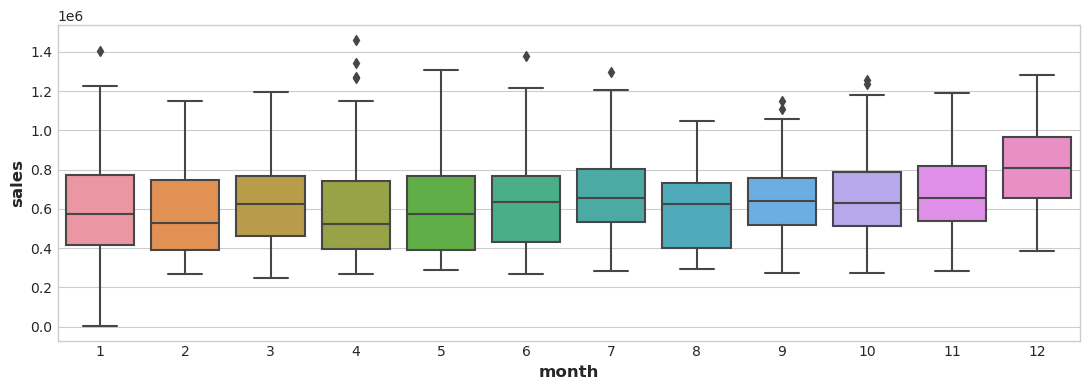

In [9]:
sns.set_style('whitegrid')

train_gp['month']=train_gp['date'].dt.month
train_gp['sales']=train_gp[list(range(1,55,1))].sum(axis=1)
sns.boxplot(data=train_gp,x='month',y='sales')


We can see the median sales are higher in December than any other month. However, there are some outliers in other months as well prompting very high sales. Let us visualize cummulative monthly sales over 5 year data.

<AxesSubplot:xlabel='month', ylabel='sales'>

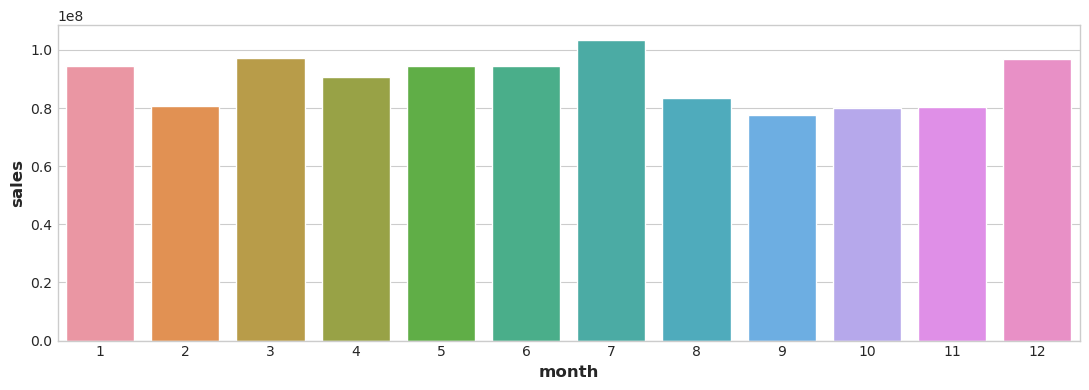

In [10]:
sns.barplot(data=train_gp[['month','sales']].groupby('month').sum('sales').reset_index(),x='month',y='sales')

Since July seems to have higher sales than December, let us see if it is due to any particular event that happended once or if it is a consistent yearly trend. Keep in mind that the training dataset does not contain August to December data for 2017 and is most probably the cause for lower sales in above chart.

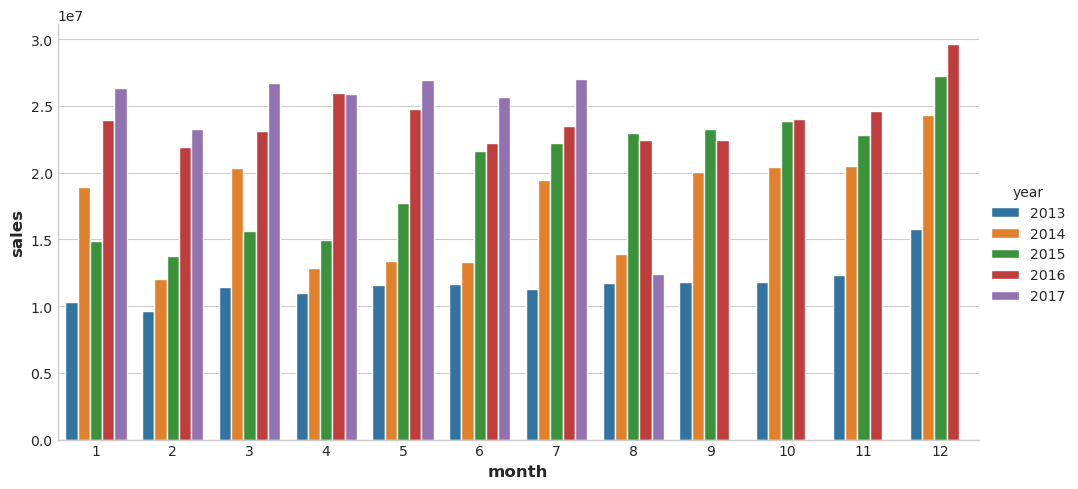

In [11]:
temp=train_gp.groupby([train_gp['date'].dt.month,train_gp['date'].dt.year]).sum()
temp=temp.drop(['month'],axis=1)
temp.reset_index([1],inplace=True)
temp.rename(columns={'date':'year'},inplace=True)
temp.reset_index(inplace=True)
temp.rename(columns={'date':'month'},inplace=True)
temp.head()
ax=sns.catplot(data=temp,x='month',y='sales',hue='year',kind='bar',aspect=2)


The plot above shows December does have actually higher sales than other months and the outliers in previous boxplot was possibly for that particular month only for individual stores that had very high sales.

We can now plot the moving average from 2013 towards 2017 to confirm the increasing trend in sales.

<AxesSubplot:title={'center':'Moving Avearage Over 1 Year Period'}, xlabel='date', ylabel='sales'>

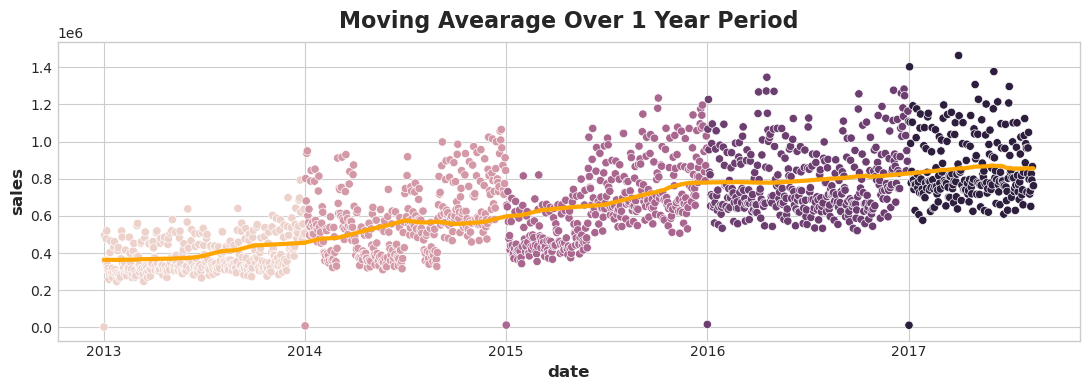

In [12]:
temp=train_gp[['sales']].rolling(window=365,min_periods=183,center=True).mean()
temp['date']=train_gp['date']
temp.set_index(['date'],inplace=True)
ax=sns.scatterplot(data=train_gp[['date','sales']],x='date',y='sales',hue=train_gp['date'].dt.year,legend=False).set(title='Moving Avearage Over 1 Year Period')
sns.lineplot(data=temp,linewidth=3,palette=['orange'],legend=False)

# Stationarity Test

We will perform Augmented Dicky Fuller test to determine if the series presented to us for forecasting is stationary or not.

The forecasting techniques available are well suited for stationary data, especially ARIMA models that are commonly proposed and discussed on Kaggle. If data is non-stationary, it can be converted into stationary series.

For now, we will use the daily average sales of all stores to determine its stationarity.

In [13]:

test_adf=train_gp.set_index('date')
test_adf=test_adf['sales']
test_adf=adfuller(test_adf,autolag='AIC',)


In [14]:
print(f'ADF statistic: {test_adf[0]}')
print(f'p-value: {test_adf[1]}')
print(f'Used lag: {test_adf[2]}')
print(f'No. of observations: {test_adf[3]}')
for key, value in test_adf[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF statistic: -2.6161957486048566
p-value: 0.08969592175787472
Used lag: 22
No. of observations: 1661
Critial Values:
   1%, -3.4342930672797065
Critial Values:
   5%, -2.8632816397229064
Critial Values:
   10%, -2.567697207194407


The ADF test has returned statistic of -2.61 with p-value of 0.089. For %5 critical value, we cannot reject the null hypothesis and conclude unit root exists. That is, the stationarity condition cannot be assumed.

We can test stationarity for first diffrenced series as well. By taking the first difference, we are expecting the series to be random walk. We will take difference between the given series and 1-day lagged series, dropping the first index since it cannot be differenced (no previous data exists to difference).

<AxesSubplot:xlabel='date', ylabel='sales'>

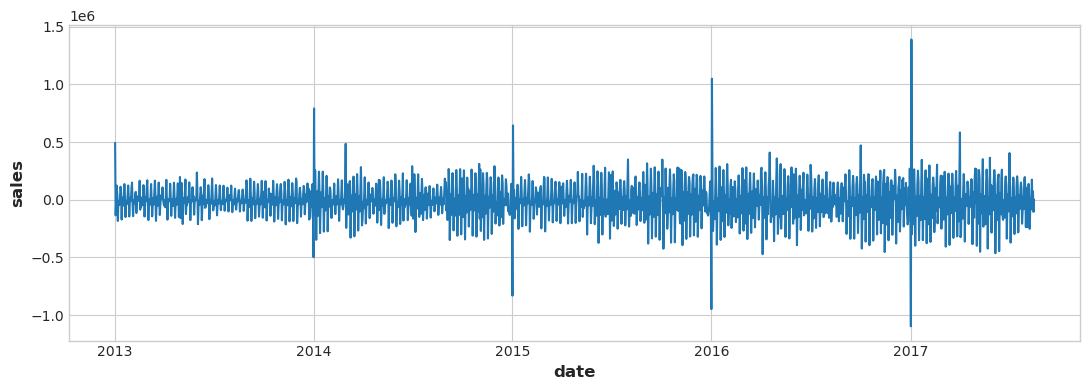

In [15]:
test_adf=train_gp.set_index('date')
test_adf=test_adf['sales']
test_adf=test_adf-test_adf.shift(1)
test_adf=test_adf.dropna()
sns.lineplot(data=test_adf)


We can see visually that variation is much more stablized in data but it appears to increase over time. First, lets perform ADF test again and then transform the data by taking log of sales to reduce the strength of variation that appears to increase over time.

In [16]:
test_adf=adfuller(test_adf,autolag='AIC')
print(f'ADF statistic: {test_adf[0]}')
print(f'p-value: {test_adf[1]}')
print(f'Used lag: {test_adf[2]}')
print(f'No. of observations: {test_adf[3]}')
for key, value in test_adf[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF statistic: -11.497599762660933
p-value: 4.573768417345458e-21
Used lag: 25
No. of observations: 1657
Critial Values:
   1%, -3.4343026006557427
Critial Values:
   5%, -2.863285847799246
Critial Values:
   10%, -2.5676994479374455


The above results suggest stationary series as expected. The p-value is extremely small**

Now let us take log of sales and then take its difference to check stationarity.

<AxesSubplot:xlabel='date', ylabel='sales'>

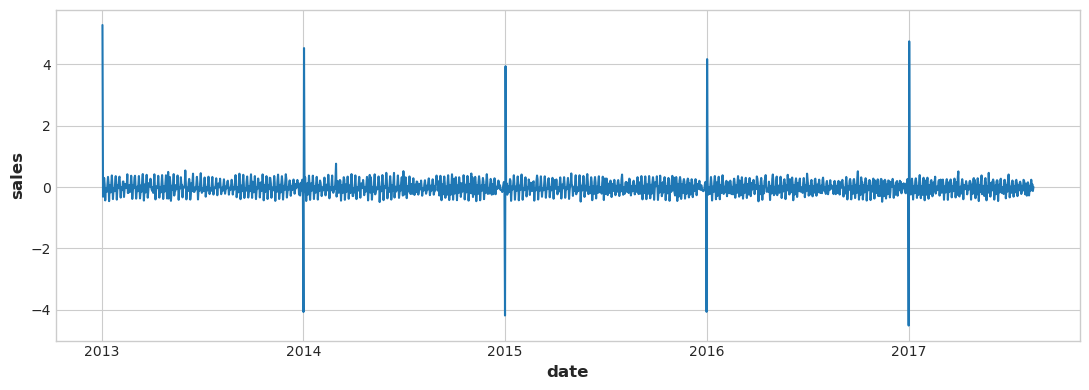

In [17]:
test_adf=train_gp.set_index('date')
test_adf=np.log(test_adf['sales'])
test_adf=test_adf-test_adf.shift(1)
test_adf=test_adf.dropna()
sns.lineplot(data=test_adf)


As we can see in the plot above, the variaiton in data appears very random and stationary. Let us perform the ADF test on transformed and differenced data.

In [18]:
test_adf=adfuller(test_adf,autolag='AIC')
print(f'ADF statistic: {test_adf[0]}')
print(f'p-value: {test_adf[1]}')
print(f'Used lag: {test_adf[2]}')
print(f'No. of observations: {test_adf[3]}')
for key, value in test_adf[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF statistic: -11.119295401138778
p-value: 3.498563849922818e-20
Used lag: 25
No. of observations: 1657
Critial Values:
   1%, -3.4343026006557427
Critial Values:
   5%, -2.863285847799246
Critial Values:
   10%, -2.5676994479374455


We have achieved lowet p-value uptill now.

# **Time Dependence: Using trend as variable**

Let us work on original sales data again.

In [19]:
y=train.set_index(['store_nbr','family','date']).sort_index()
y.drop(['id','onpromotion'],axis=1,inplace=True)
y.head()


sales
store_nbr family     date             
1         AUTOMOTIVE 2013-01-01    0.0
                     2013-01-02    2.0
                     2013-01-03    3.0
                     2013-01-04    3.0
                     2013-01-05    5.0

In [20]:
y=y.unstack(['store_nbr','family']).droplevel(0,axis=1) #The droplevel method is used as the previous set_index method adds None column
y.head()


store_nbr          1                                                 \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0        0.000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0      470.652   
2013-01-03        3.0       0.0    0.0     919.0   0.0      310.655   
2013-01-04        3.0       0.0    3.0     953.0   0.0      198.366   
2013-01-05        5.0       0.0    3.0    1160.0   0.0      301.057   

store_nbr                                        ...        54          \
family     CELEBRATION CLEANING  DAIRY     DELI  ... MAGAZINES   MEATS   
date                                             ...                     
2013-01-01         0.0      0.0    0.0    0.000  ...       0.0   0.000   
2013-01-02         0.0   1060.0  579.0  164.069  ...       0.0  73.771   
2013-01-03         0.0    836.0  453.0  151.582  ...       0.0  50.257   
2013-01-04         0.0    827.0  460.0  131.411  ...       0.0  40.223   
2013-01-05         0.0    811.0  464.0  118.613  ...       0.0  43.431   

store_nbr                                                              \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2013-01-01           0.0          0.0                     0.0   0.000   
2013-01-02         228.0          0.0                     0.0  15.514   
2013-01-03         156.0          0.0                     0.0   4.313   
2013-01-04         146.0          0.0                     0.0  26.743   
2013-01-05         205.0          0.0                     0.0  31.118   

store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01            0.0     0.0                        0.0     0.0  
2013-01-02           61.0     0.0                        0.0     3.0  
2013-01-03            1.0     0.0                        0.0     2.0  
2013-01-04           38.0     0.0                        0.0     2.0  
2013-01-05           32.0     0.0                        0.0     1.0  

[5 rows x 1782 columns]

In [21]:
#Creating 3rd order variables for trend
dp=DeterministicProcess(index=y.index,constant=True,order=3,drop=True)
X=dp.in_sample()
X.head()

const  trend  trend_squared  trend_cubed
date                                                
2013-01-01    1.0    1.0            1.0          1.0
2013-01-02    1.0    2.0            4.0          8.0
2013-01-03    1.0    3.0            9.0         27.0
2013-01-04    1.0    4.0           16.0         64.0
2013-01-05    1.0    5.0           25.0        125.0

In [22]:
#Fitting the data using linear regression. The training data we take is the trend (an integer incrementing alond with date), it's squared and cubed values.
#The target data is the sales record of store for all the respective dates.
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=15,shuffle=False)
LM=LinearRegression(fit_intercept=False)
LM.fit(X_train,y_train)

LinearRegression(fit_intercept=False)

Note that this is multi-target regression. The shape of the coefficients show that we have 4 coefficients for each of the column/target (for example AUTOMOTIVE in store 1)
Resultingly, we have 1782 sets of 4-coefficients, each set of 4-coefficients for predicting 1 target.

In [23]:
LM.coef_.shape

(1782, 4)

# Prediction using trend

In [24]:
#Predicting from trained coefficients, predicting training data itself first. We convert the prediction into a dataframe as well.
y_fit=pd.DataFrame(LM.predict(X_train),index=X_train.index,columns=y_train.columns).clip(0.0).round(1)
y_pred=pd.DataFrame(LM.predict(X_test),index=X_test.index,columns=y_test.columns).clip(0.0).round(1)
y_pred.head()


store_nbr          1                                                 \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-08-01        4.0       0.0    3.5    2196.6   0.7        343.6   
2017-08-02        4.0       0.0    3.5    2196.6   0.7        343.4   
2017-08-03        4.0       0.0    3.5    2196.5   0.7        343.1   
2017-08-04        4.0       0.0    3.5    2196.4   0.7        342.8   
2017-08-05        4.0       0.0    3.5    2196.3   0.7        342.6   

store_nbr                                      ...        54        \
family     CELEBRATION CLEANING  DAIRY   DELI  ... MAGAZINES MEATS   
date                                           ...                   
2017-08-01        14.9    652.1  723.4  125.1  ...       1.1  53.8   
2017-08-02        14.9    652.0  723.3  125.1  ...       1.1  53.8   
2017-08-03        14.8    651.9  723.2  125.0  ...       1.1  53.8   
2017-08-04        14.8    651.8  723.1  124.9  ...       1.1  53.8   
2017-08-05        14.8    651.7  723.1  124.9  ...       1.1  53.7   

store_nbr                                                              \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2017-08-01         185.0          0.2                     4.1    68.3   
2017-08-02         184.8          0.2                     4.1    68.4   
2017-08-03         184.6          0.2                     4.1    68.5   
2017-08-04         184.5          0.2                     4.1    68.5   
2017-08-05         184.3          0.2                     4.1    68.6   

store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2017-08-01           80.6   678.3                        3.1     2.8  
2017-08-02           80.7   678.1                        3.1     2.8  
2017-08-03           80.7   678.0                        3.1     2.8  
2017-08-04           80.7   677.9                        3.1     2.8  
2017-08-05           80.8   677.7                        3.1     2.8  

[5 rows x 1782 columns]

In [25]:
# Calculating Root Mean Squared Log Error
RMSLE_train=mean_squared_log_error(y_train,y_fit)**0.5
RMSLE_pred=mean_squared_log_error(y_test,y_pred)**0.5
print(f'Root Mean Squared Log Error for Training Data: {RMSLE_train:.3f}')
print(f'Root Mean Squared Log Error for Prediction Data: {RMSLE_pred:.3f}')

Root Mean Squared Log Error for Training Data: 1.089
Root Mean Squared Log Error for Prediction Data: 0.594


In [26]:
#We can compare some arbitrary true values and predicted values side by side. Lets compare sales of store id 24's PERSONAL CARE section
comparison=pd.DataFrame(y_test.loc['2017-07-27':'2017-08-05',(24,'PERSONAL CARE')])
comparison['fitted']=y_pred.loc['2017-07-27':'2017-08-05',(24,'PERSONAL CARE')]
comparison.columns=['Training data','Predicted data']
comparison.head(15)

Training data  Predicted data
date                                     
2017-08-01          359.0           259.1
2017-08-02          348.0           258.7
2017-08-03          271.0           258.2
2017-08-04          270.0           257.8
2017-08-05          353.0           257.4

Let us see the difference between actual and fitted data of training set for arbitrarily selected store (store#5) and first 20 product families.

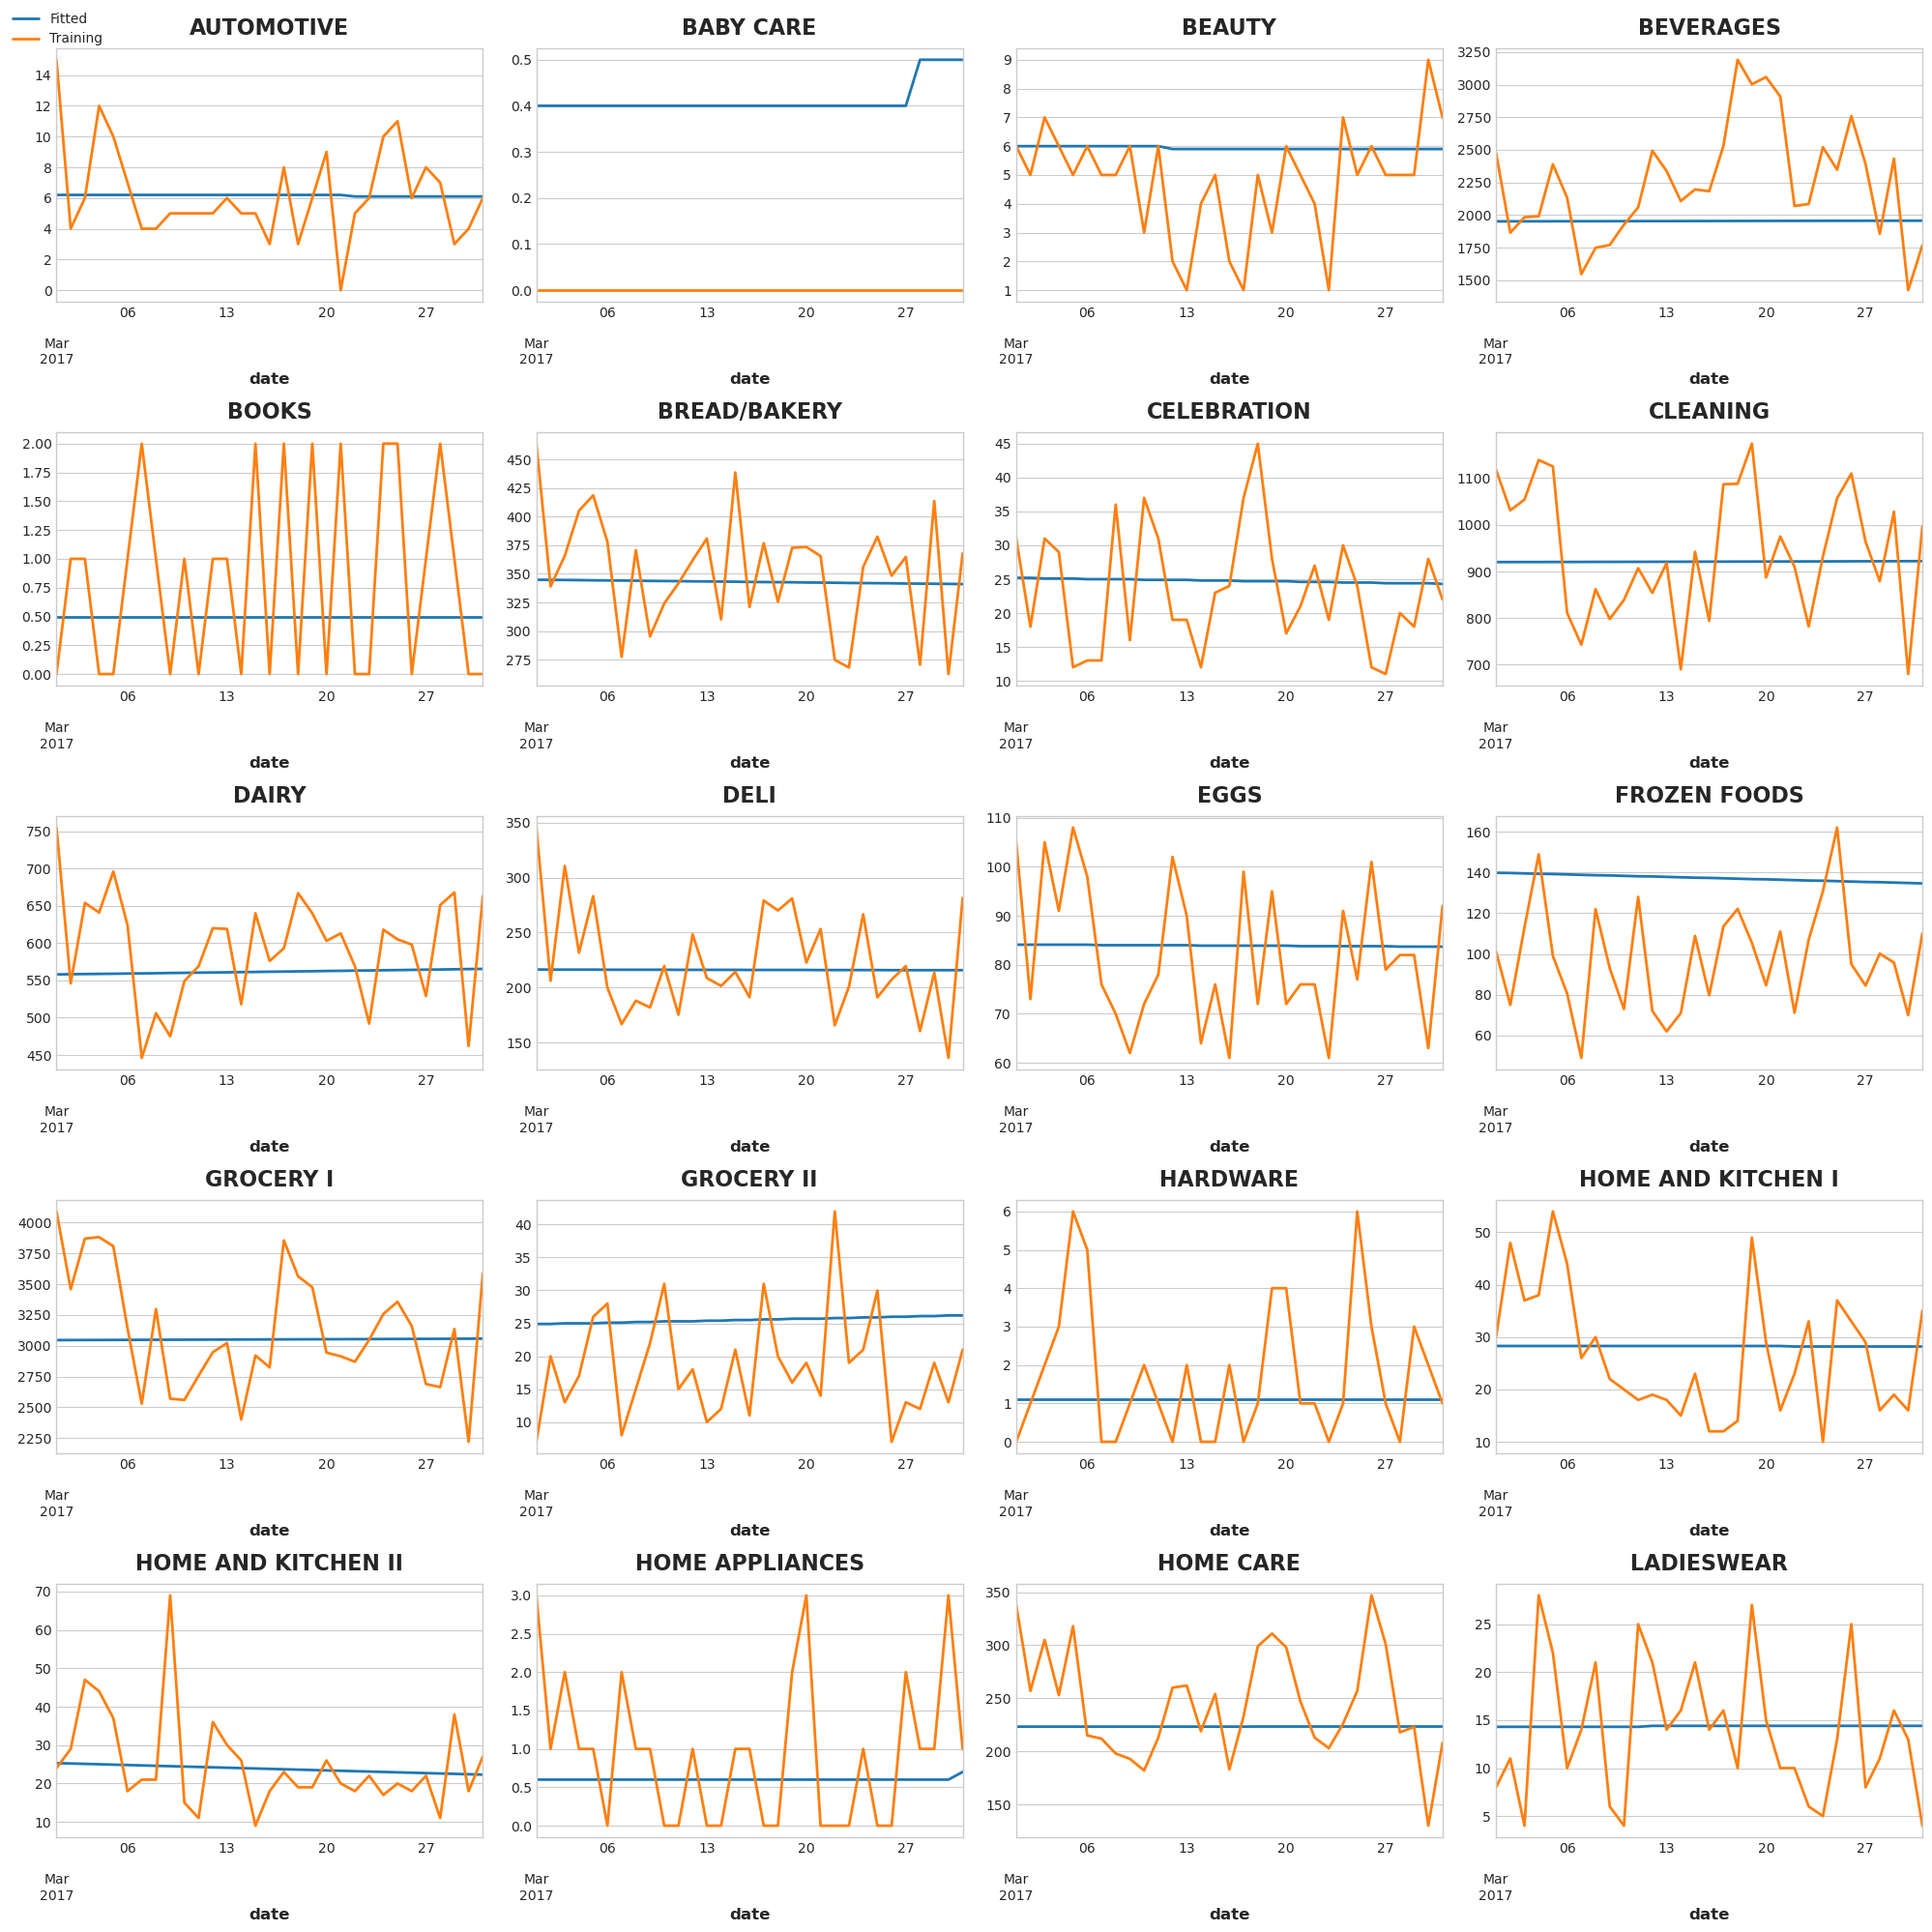

In [27]:
fig,ax=plt.subplots(5,4,figsize=(20,20))
x_axis=0
y_axis=0
lim=0
for i in y_fit.columns.unique():
    if (i[0]==5) and (lim<20):
        y_fit.loc['2017-03-01':'2017-03-31',i].plot(legend=False,ax=ax[x_axis,y_axis],linewidth=2)
        y_train.loc['2017-03-01':'2017-03-31',i].plot(legend=False,ax=ax[x_axis,y_axis],linewidth=2)
        ax[x_axis,y_axis].set_title(i[1])
        x_axis=x_axis+1 if y_axis==3 else x_axis
        y_axis=y_axis+1 if y_axis<3 else 0
        lim=lim+1
    
plt.tight_layout(pad = 1.5)
handles,labels=plt.gca().get_legend_handles_labels()
fig.legend(handles,['Fitted','Training'],loc='upper left')
plt.show()

We can see in the plots above that our model in blue line does not match well the variaitions of actual data in orange.

We will now add seasonal features to model such variations better.

# Seasonal features

By adding seasonal features, we are trying to introduce data points in our training data that indicate start and end of a season. This season can be an yearly season, so we indicate start and end of a year. We can indicate monthly season, so we indicate start and end of a month, and so on. This can be done by adding sine and cosine pair data. Assuming you have basic knowledge of sine and cosine, these functions have a periodic behavior. Let us say we use a cosine to indicate start and end of an year, then the first day of the year will be the point where cosine starts (cosine starts with the peak value of 1) and slowly it completes 1 cycle in an year (cycling the value from 1 to 0 to -1 to 0 and back to 1) such that when next year arrives, the first day of the new year will again have a value of 1. The sine will also repeat its 1 cycle in that year, however, sine will start with the value of 0. So now we have a sine and cosine pair that completes 1 cycle a year and the values of sine and cosine throughout that year represent the yearly season. Why sine and cosine pair? The answer is Fourier series, which can be reviewed independently. In short, we are forcing the dataset to contain a yearly season. Why do we do so? The periodogram tells us if yearly season is actually present in data. If sales in the store have a behvaior such that specific parts of the year have certain kind of trend in sales (for example high sales near christmas) then the seasonal data will help us reflect it in our model.

<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

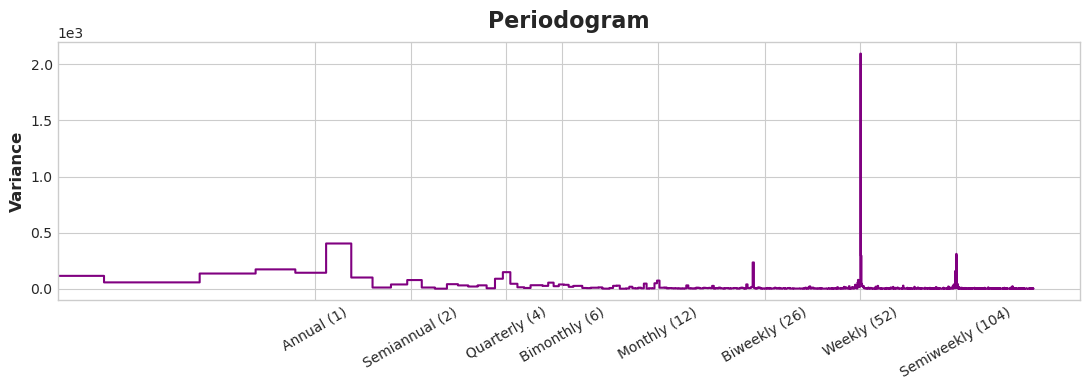

In [28]:
average_sales = train.groupby('date').mean()['sales']
average_sales.head()
plot_periodogram(average_sales)

The periodogram shows magnitude of different seasonal trends that were strong in provided time series. The strongest component is clerly the weekly season. We will come back to wekly and semiweekly while we stop just before that and focus uptil the last strong magnitude at biweekly season.

In [29]:
#creating y dataset again like before
y=train.set_index(['store_nbr','family','date']).sort_index()
y.drop(['id','onpromotion'],axis=1,inplace=True)
y=y.unstack(['store_nbr','family']).droplevel(0,axis=1)
y=y.asfreq('D') #DeterministicProcess requires frequency of index to be available so we set it as daily 'D'
fourier=CalendarFourier(freq='M',order=4) # with order=4, we get 8 sines/cosines (4 pairs) to model 'M' monthly season.
dp=DeterministicProcess(index=y.index,constant=True,order=3,seasonal=True,additional_terms=[fourier],drop=True)
X=dp.in_sample() #The in_sample() method generates required components at time indexes provided in index argument of DeterministicProcess.
y.drop(index=['2013-12-25','2014-12-25','2015-12-25','2016-12-25'],inplace=True) #y.asfreq('D') added these dates to data which were not present in original data
X.drop(index=['2013-12-25','2014-12-25','2015-12-25','2016-12-25'],inplace=True)


In [30]:
X.head()

const  trend  trend_squared  trend_cubed  s(2,7)  s(3,7)  s(4,7)  \
date                                                                           
2013-01-01    1.0    1.0            1.0          1.0     0.0     0.0     0.0   
2013-01-02    1.0    2.0            4.0          8.0     1.0     0.0     0.0   
2013-01-03    1.0    3.0            9.0         27.0     0.0     1.0     0.0   
2013-01-04    1.0    4.0           16.0         64.0     0.0     0.0     1.0   
2013-01-05    1.0    5.0           25.0        125.0     0.0     0.0     0.0   

            s(5,7)  s(6,7)  s(7,7)  sin(1,freq=M)  cos(1,freq=M)  \
date                                                               
2013-01-01     0.0     0.0     0.0       0.000000       1.000000   
2013-01-02     0.0     0.0     0.0       0.201299       0.979530   
2013-01-03     0.0     0.0     0.0       0.394356       0.918958   
2013-01-04     0.0     0.0     0.0       0.571268       0.820763   
2013-01-05     1.0     0.0     0.0       0.724793       0.688967   

            sin(2,freq=M)  cos(2,freq=M)  sin(3,freq=M)  cos(3,freq=M)  \
date                                                                     
2013-01-01       0.000000       1.000000       0.000000       1.000000   
2013-01-02       0.394356       0.918958       0.571268       0.820763   
2013-01-03       0.724793       0.688967       0.937752       0.347305   
2013-01-04       0.937752       0.347305       0.968077      -0.250653   
2013-01-05       0.998717      -0.050649       0.651372      -0.758758   

            sin(4,freq=M)  cos(4,freq=M)  
date                                      
2013-01-01       0.000000       1.000000  
2013-01-02       0.724793       0.688967  
2013-01-03       0.998717      -0.050649  
2013-01-04       0.651372      -0.758758  
2013-01-05      -0.101168      -0.994869

Let us review the newly constructed dataframe X. The 'const' and 'trend' terms are same as before.'s(2,7)' to 's(7,7)' are seasonal indicators for weekly data. Remember we ignored weekly and semiweekly trend from periodogram? These terms are better modeled with indicators for 7 days 's(2,7)' to 's(7,7)' where s(1,7) was dropped. You can see for example s(2,7) will be set to 1 after every 7 day interval. Same goes for other indicators.

The sin(1,freq=M) models a sinusoidal that should complete 1 cycle every month. Same goes for cos(1,freq=M). Note that sin start with 0 and cos starts with 1. As for remaining  terms, sin(2,freq=M) should complete 2 cycles evry month, sin(3,freq=M) completes 3 cycles every month, sin(4,freq=M) completes 4 cycles every month.

The sin cosine plots below show these cycles for first month of data.

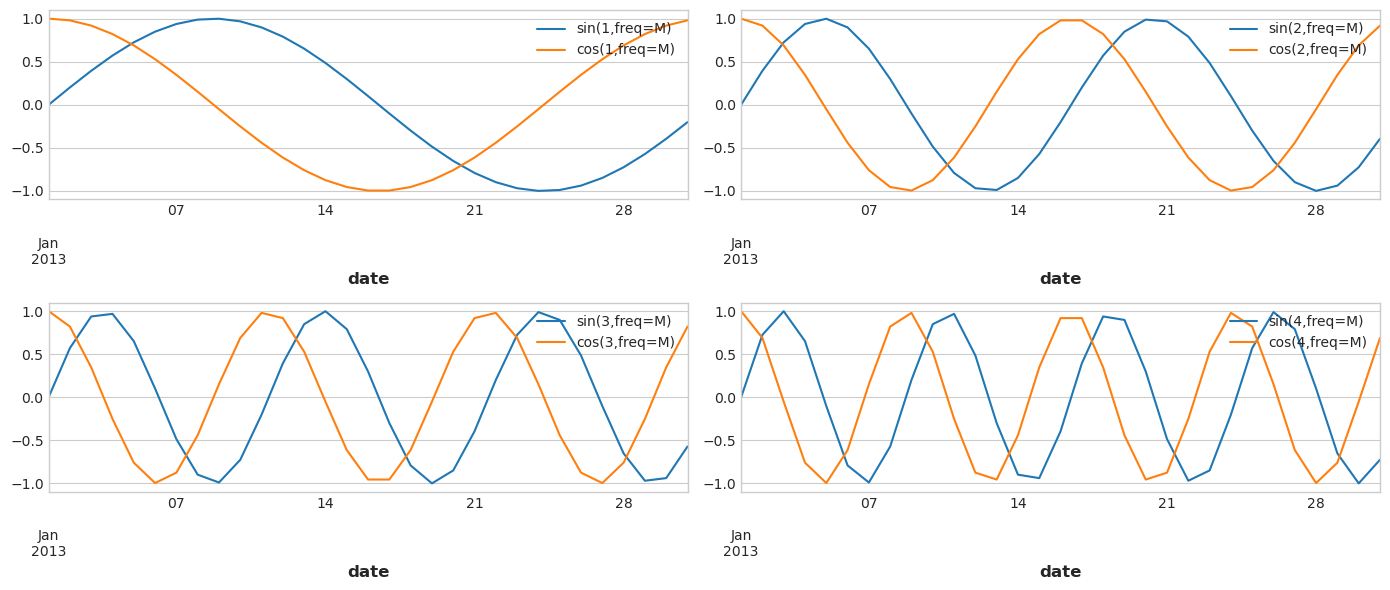

In [31]:
fig,ax=plt.subplots(2,2,figsize=(14,6))
X.loc['2013-01-01':'2013-01-31',['sin(1,freq=M)','cos(1,freq=M)']].plot(ax=ax[0,0]).legend(loc='upper right')
X.loc['2013-01-01':'2013-01-31',['sin(2,freq=M)','cos(2,freq=M)']].plot(ax=ax[0,1]).legend(loc='upper right')
X.loc['2013-01-01':'2013-01-31',['sin(3,freq=M)','cos(3,freq=M)']].plot(ax=ax[1,0]).legend(loc='upper right')
X.loc['2013-01-01':'2013-01-31',['sin(4,freq=M)','cos(4,freq=M)']].plot(ax=ax[1,1]).legend(loc='upper right')
plt.show()

# Prediction using seasonal features

In [32]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=15,shuffle=False)
LM=LinearRegression(fit_intercept=False)
LM.fit(X_train,y_train)

LinearRegression(fit_intercept=False)

In [33]:
y_fit=pd.DataFrame(LM.predict(X_train),index=X_train.index,columns=y_train.columns).clip(0.0).round(1)
y_pred=pd.DataFrame(LM.predict(X_test),index=X_test.index,columns=y_test.columns).clip(0.0).round(1)
# Calculating Root Mean Squared Log Error
RMSLE_train=mean_squared_log_error(y_train,y_fit)**0.5
RMSLE_pred=mean_squared_log_error(y_test,y_pred)**0.5
print(f'Root Mean Squared Log Error for Training Data: {RMSLE_train:.3f}')
print(f'Root Mean Squared Log Error for Prediction Data: {RMSLE_pred:.3f}')

Root Mean Squared Log Error for Training Data: 1.088
Root Mean Squared Log Error for Prediction Data: 0.578


Let us use the same code we used earlier to see how our new model fares of with actual data for 20 products at store number 5 for 1 month data.

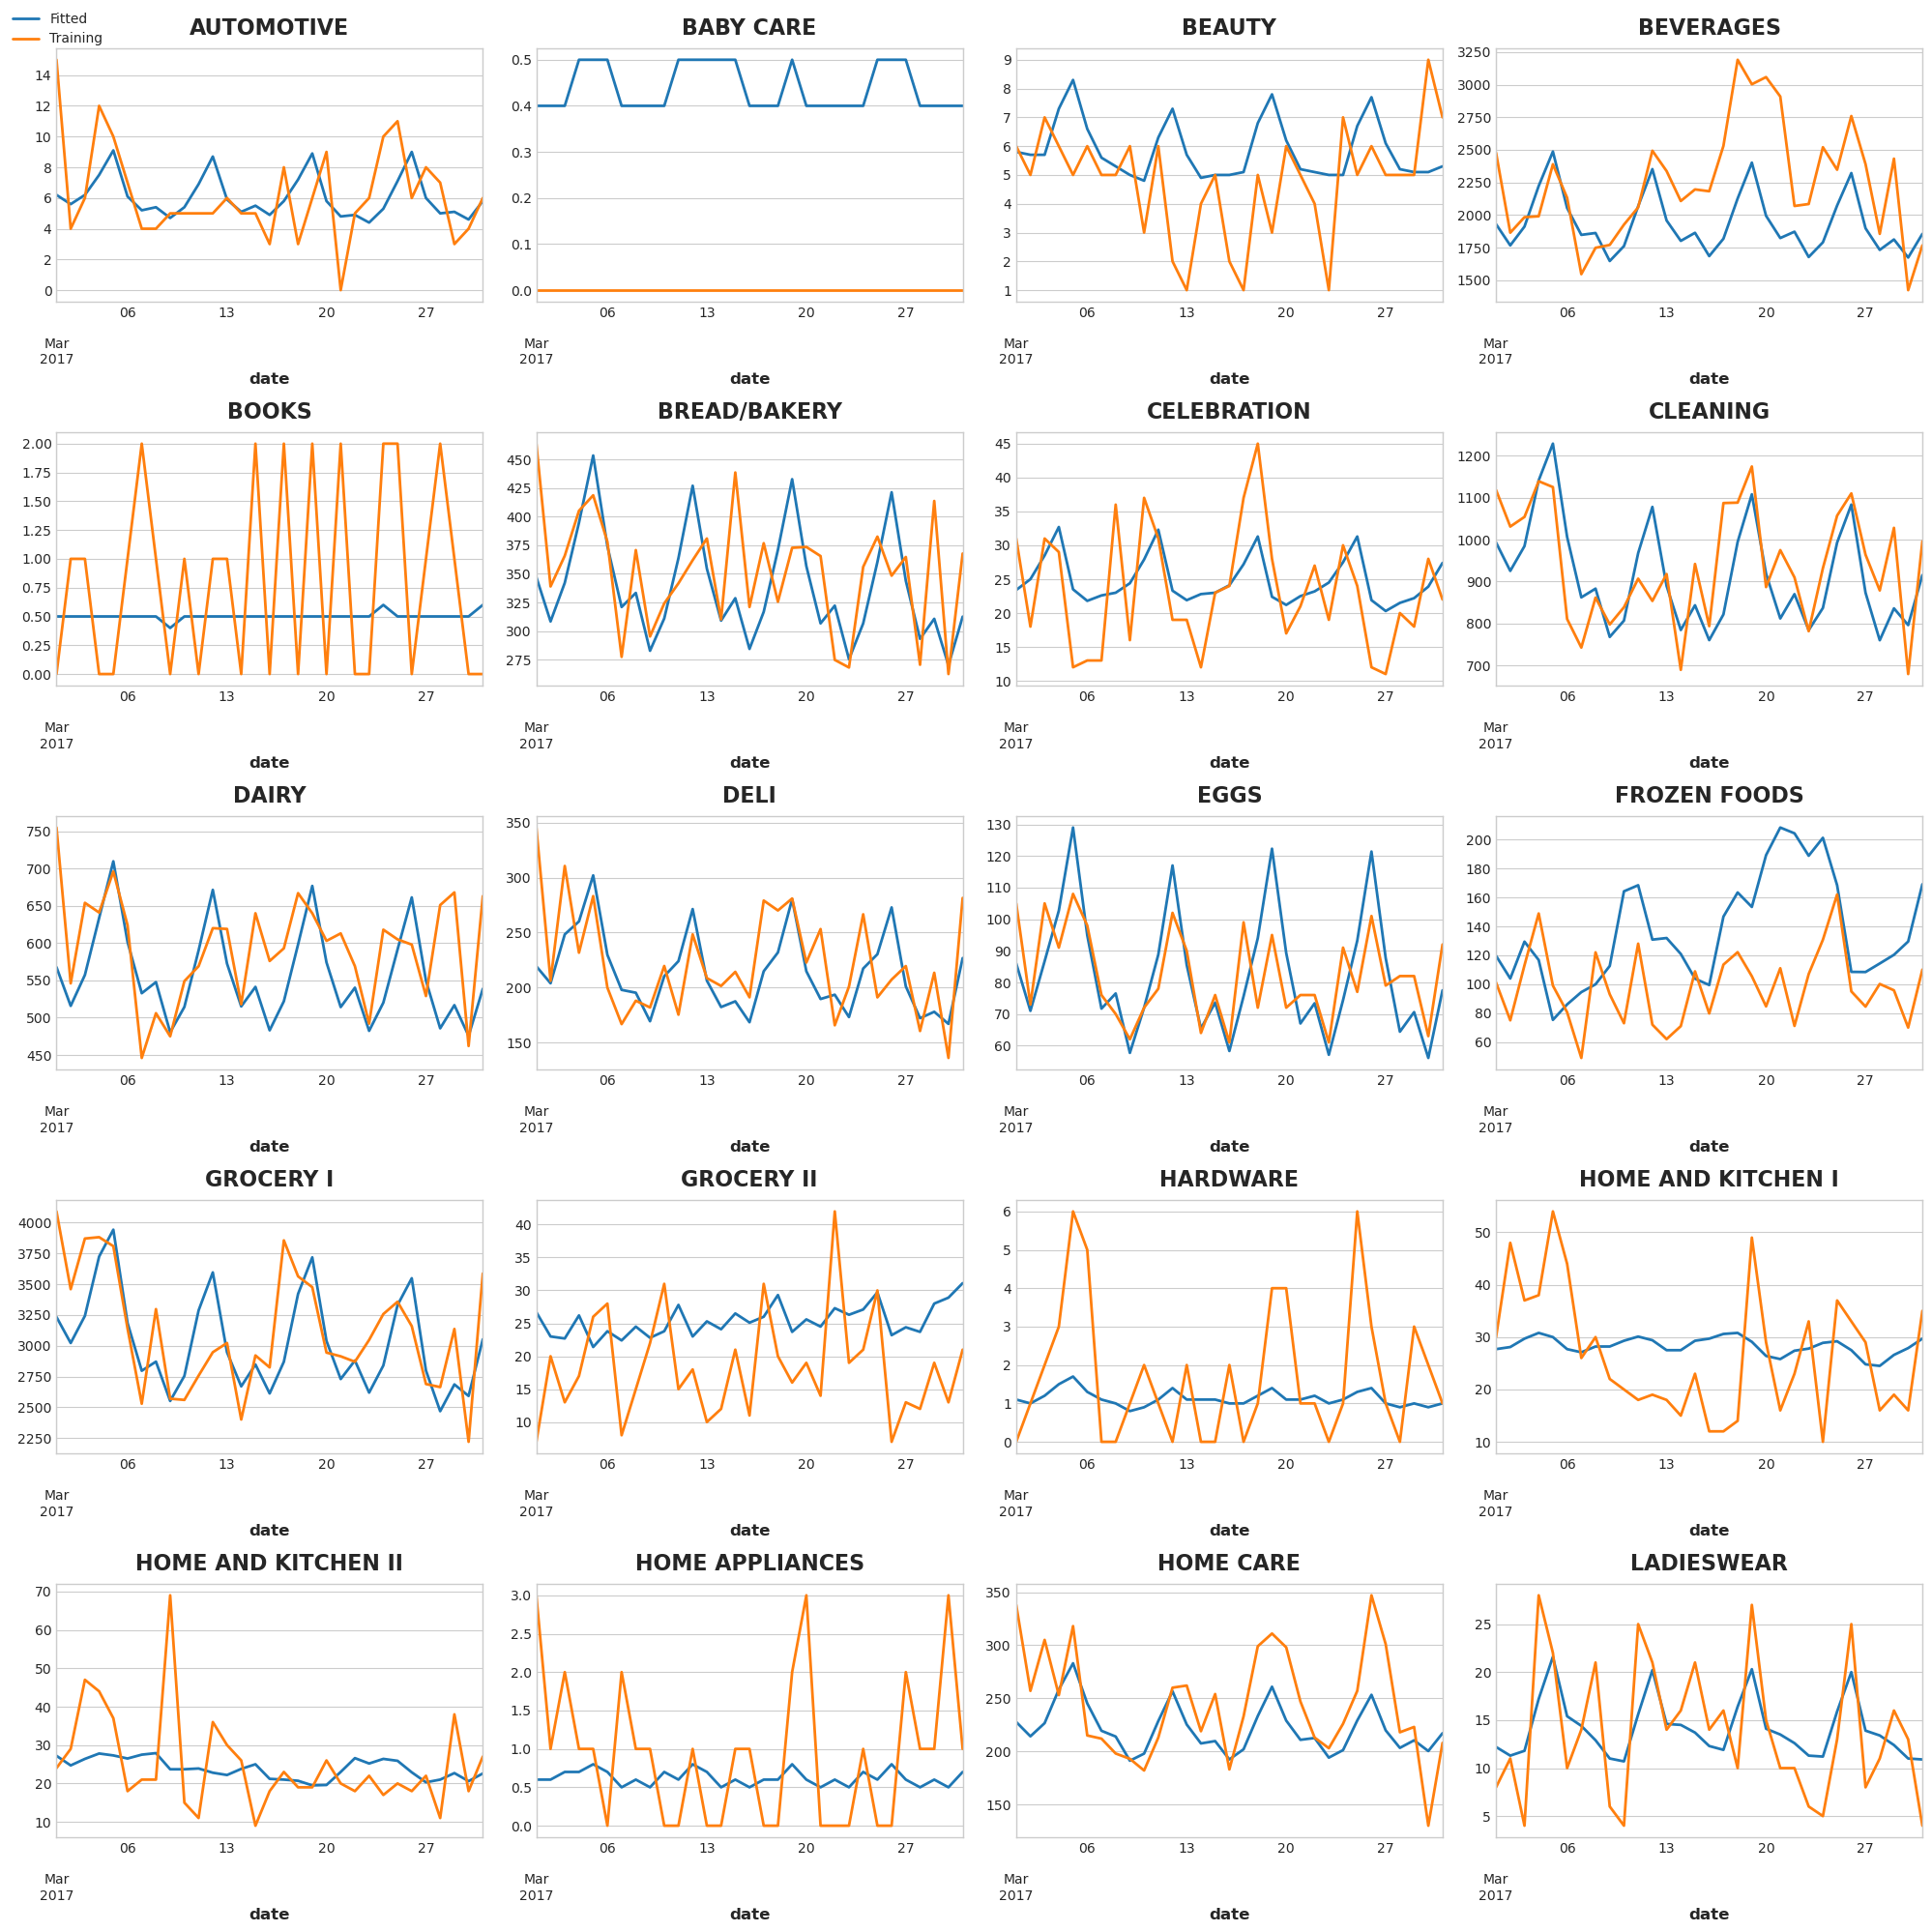

In [34]:
fig,ax=plt.subplots(5,4,figsize=(20,20))
x_axis=0
y_axis=0
lim=0
for i in y_fit.columns.unique():
    if (i[0]==5) and (lim<20):
        y_fit.loc['2017-03-01':'2017-03-31',i].plot(legend=False,ax=ax[x_axis,y_axis],linewidth=2)
        y_train.loc['2017-03-01':'2017-03-31',i].plot(legend=False,ax=ax[x_axis,y_axis],linewidth=2)
        ax[x_axis,y_axis].set_title(i[1])
        x_axis=x_axis+1 if y_axis==3 else x_axis
        y_axis=y_axis+1 if y_axis<3 else 0
        lim=lim+1
    
plt.tight_layout(pad = 1.5)
handles,labels=plt.gca().get_legend_handles_labels()
fig.legend(handles,['Fitted','Training'],loc='upper left')
plt.show()

Compared to the first model, the current model has lot more fluctuations trying to capture the data. 

# Preparation for submission

Let us now create data for submission. We will create the input data from the recently created deterministic process X.

In [35]:
X_submit=dp.out_of_sample(steps=16)
X_submit.index.name='date'
y_submit=pd.DataFrame(LM.predict(X_submit),index=X_submit.index,columns=y_test.columns).clip(0.0)
y_submit=y_submit.stack(['store_nbr','family']) #This arranges data in required format for submission
y_submit=pd.DataFrame(y_submit).rename(columns={0:'sales'}) #converting into dataframe and naming column to sales
test_new=test.set_index(['date','store_nbr','family']).sort_index()
y_submit=y_submit.droplevel([1,2],axis=0).reset_index() #dropping 'store_nbr' and 'family' levels in the index
test_new=test_new.droplevel([1,2],axis=0).reset_index().drop(['date','onpromotion'],axis=1)
y_submit=pd.concat([y_submit,test_new],axis=1) #combining test set for id and y_submit for sales 
y_submit=y_submit.drop(['date'],axis=1).reindex(columns=['id','sales']) #dropping irrelevant columns and rearranging
y_submit=y_submit.sort_values(['id'])
y_submit.to_csv('submission1.csv',index=False)

We submit the above model and consider it our first submission. The public score comes out as 0.634

We now create more models by adjusting some the charecteristics of the model and picking out dates from training data.

In [36]:
########### Monthly Fourier components with order 2, 2017 dates
y=train.set_index(['store_nbr','family','date']).sort_index()
y.drop(['id','onpromotion'],axis=1,inplace=True)
y=y.unstack(['store_nbr','family']).droplevel(0,axis=1)
y=y.loc['2017-01-01':'2017-08-15',:]
y=y.asfreq('D')
fourier=CalendarFourier(freq='M',order=2)
dp=DeterministicProcess(index=y.index,constant=True,order=3,seasonal=True,additional_terms=[fourier],drop=True)
X=dp.in_sample()
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=15,shuffle=False)
LM=LinearRegression(fit_intercept=False)
LM.fit(X_train,y_train)
X_submit=dp.out_of_sample(steps=16)
X_submit.index.name='date'
y_submit=pd.DataFrame(LM.predict(X_submit),index=X_submit.index,columns=y_test.columns).clip(0.0)
y_submit=y_submit.stack(['store_nbr','family']) #This arranges data in required format for submission
y_submit=pd.DataFrame(y_submit).rename(columns={0:'sales'}) #converting into dataframe and naming column to sales
test_new=test.set_index(['date','store_nbr','family']).sort_index()
y_submit=y_submit.droplevel([1,2],axis=0).reset_index() #dropping 'store_nbr' and 'family' levels in the index
test_new=test_new.droplevel([1,2],axis=0).reset_index().drop(['date','onpromotion'],axis=1)
y_submit=pd.concat([y_submit,test_new],axis=1) #combining test set for id and y_submit for sales 
y_submit=y_submit.drop(['date'],axis=1).reindex(columns=['id','sales']) #dropping irrelevant columns and rearranging
y_submit=y_submit.sort_values(['id'])
y_submit.to_csv('submission2.csv',index=False)

The second model considers 2017 dates only with monthly fourier components having order 2. The public score after submission comes out as 0.786.

In [37]:
########### Monthly Fourier components with order 4, 2017 dates
y=train.set_index(['store_nbr','family','date']).sort_index()
y.drop(['id','onpromotion'],axis=1,inplace=True)
y=y.unstack(['store_nbr','family']).droplevel(0,axis=1)
y=y.loc['2017-01-01':'2017-08-15',:]
y=y.asfreq('D')
fourier=CalendarFourier(freq='M',order=4)
dp=DeterministicProcess(index=y.index,constant=True,order=3,seasonal=True,additional_terms=[fourier],drop=True)
X=dp.in_sample()
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=15,shuffle=False)
LM=LinearRegression(fit_intercept=False)
LM.fit(X_train,y_train)
X_submit=dp.out_of_sample(steps=16)
X_submit.index.name='date'
y_submit=pd.DataFrame(LM.predict(X_submit),index=X_submit.index,columns=y_test.columns).clip(0.0)
y_submit=y_submit.stack(['store_nbr','family']) #This arranges data in required format for submission
y_submit=pd.DataFrame(y_submit).rename(columns={0:'sales'}) #converting into dataframe and naming column to sales
test_new=test.set_index(['date','store_nbr','family']).sort_index()
y_submit=y_submit.droplevel([1,2],axis=0).reset_index() #dropping 'store_nbr' and 'family' levels in the index
test_new=test_new.droplevel([1,2],axis=0).reset_index().drop(['date','onpromotion'],axis=1)
y_submit=pd.concat([y_submit,test_new],axis=1) #combining test set for id and y_submit for sales 
y_submit=y_submit.drop(['date'],axis=1).reindex(columns=['id','sales']) #dropping irrelevant columns and rearranging
y_submit=y_submit.sort_values(['id'])
y_submit.to_csv('submission3.csv',index=False)

The third model considers 2017 dates only with monthly fourier components having order 4. The public score after submission comes out as 0.785.

In [38]:
########### Annual Fourier components with order 12, 2016-2017 dates
y=train.set_index(['store_nbr','family','date']).sort_index()
y.drop(['id','onpromotion'],axis=1,inplace=True)
y=y.unstack(['store_nbr','family']).droplevel(0,axis=1)
y=y.loc['2016-01-01':'2017-08-15',:]
y=y.asfreq('D')
fourier=CalendarFourier(freq='Y',order=12)
dp=DeterministicProcess(index=y.index,constant=True,order=3,seasonal=True,additional_terms=[fourier],drop=True)
X=dp.in_sample()
X.drop(index=['2016-12-25'],inplace=True)
y.drop(index=['2016-12-25'],inplace=True)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=15,shuffle=False)
LM=LinearRegression(fit_intercept=False)
LM.fit(X_train,y_train)
X_submit=dp.out_of_sample(steps=16)
X_submit.index.name='date'
y_submit=pd.DataFrame(LM.predict(X_submit),index=X_submit.index,columns=y_test.columns).clip(0.0)
y_submit=y_submit.stack(['store_nbr','family']) #This arranges data in required format for submission
y_submit=pd.DataFrame(y_submit).rename(columns={0:'sales'}) #converting into dataframe and naming column to sales
test_new=test.set_index(['date','store_nbr','family']).sort_index()
y_submit=y_submit.droplevel([1,2],axis=0).reset_index() #dropping 'store_nbr' and 'family' levels in the index
test_new=test_new.droplevel([1,2],axis=0).reset_index().drop(['date','onpromotion'],axis=1)
y_submit=pd.concat([y_submit,test_new],axis=1) #combining test set for id and y_submit for sales 
y_submit=y_submit.drop(['date'],axis=1).reindex(columns=['id','sales']) #dropping irrelevant columns and rearranging
y_submit=y_submit.sort_values(['id'])
y_submit.to_csv('submission4.csv',index=False)

The fourth model considers 2016-2017 dates only with annual fourier components having order 12. The public score after submission comes out as 0.77.

In [39]:
########### Annual Fourier components with order 4, 2016-2017 dates

y=train.set_index(['store_nbr','family','date']).sort_index()
y.drop(['id','onpromotion'],axis=1,inplace=True)
y=y.unstack(['store_nbr','family']).droplevel(0,axis=1)
y=y.loc['2016-01-01':'2017-08-15',:]
y=y.asfreq('D')
fourier=CalendarFourier(freq='Y',order=4)
dp=DeterministicProcess(index=y.index,constant=True,order=3,seasonal=True,additional_terms=[fourier],drop=True)
X=dp.in_sample()
X.drop(index=['2016-12-25'],inplace=True)
y.drop(index=['2016-12-25'],inplace=True)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=15,shuffle=False)
LM=LinearRegression(fit_intercept=False)
LM.fit(X_train,y_train)
X_submit=dp.out_of_sample(steps=16)
X_submit.index.name='date'
y_submit=pd.DataFrame(LM.predict(X_submit),index=X_submit.index,columns=y_test.columns).clip(0.0)
y_submit=y_submit.stack(['store_nbr','family']) #This arranges data in required format for submission
y_submit=pd.DataFrame(y_submit).rename(columns={0:'sales'}) #converting into dataframe and naming column to sales
test_new=test.set_index(['date','store_nbr','family']).sort_index()
y_submit=y_submit.droplevel([1,2],axis=0).reset_index() #dropping 'store_nbr' and 'family' levels in the index
test_new=test_new.droplevel([1,2],axis=0).reset_index().drop(['date','onpromotion'],axis=1)
y_submit=pd.concat([y_submit,test_new],axis=1) #combining test set for id and y_submit for sales 
y_submit=y_submit.drop(['date'],axis=1).reindex(columns=['id','sales']) #dropping irrelevant columns and rearranging
y_submit=y_submit.sort_values(['id'])
y_submit.to_csv('submission5.csv',index=False)

The fifth model considers 2016-2017 dates only with annual fourier components having order 4. The public score after submission comes out as 0.674.

Let us include holidays data in the first model which provided best public score so far.


In [40]:
#Arranging holidays data for use with data
holidays2=holidays.where((holidays['locale']=="National") | (holidays['locale']=="Regional")) #filtering out local holidays
holidays2=holidays2[['date','locale','description']]
holidays2=holidays2[~holidays2['date'].isna()] #the where() method returned NaN where region was not national or regional, so ignoring all NaN rows
holidays2.drop('locale',inplace=True,axis=1)
holidays2=holidays2.query('"2013-01-01"<= date <="2017-08-15"') #training set comprises of these dates only
holidays2.drop_duplicates(subset=['date'],inplace=True) #holidays dataset contains some multiple holidays on same date, removing those duplicates here
holidays2.set_index('date',inplace=True)
holidays2=pd.get_dummies(holidays2) #holidays given in 'description' column treated as dummy indicators

#Using the best model so far from first submission
y=train.set_index(['store_nbr','family','date']).sort_index()
y.drop(['id','onpromotion'],axis=1,inplace=True)
y=y.unstack(['store_nbr','family']).droplevel(0,axis=1)
y=y.asfreq('D')
fourier=CalendarFourier(freq='M',order=4)
dp=DeterministicProcess(index=y.index,constant=True,order=3,seasonal=True,additional_terms=[fourier],drop=True)
X=dp.in_sample()
y.drop(index=['2013-12-25','2014-12-25','2015-12-25','2016-12-25'],inplace=True)
X.drop(index=['2013-12-25','2014-12-25','2015-12-25','2016-12-25'],inplace=True)
X.head()

#Joining holiday data with X, the dates missing in holidays dataset are filled with NaN so replacing hose with 0.0
X_h=X.join(holidays2,on='date').fillna(0.0) #X_h for X_holidays
X_h.head()

const  trend  trend_squared  trend_cubed  s(2,7)  s(3,7)  s(4,7)  \
date                                                                           
2013-01-01    1.0    1.0            1.0          1.0     0.0     0.0     0.0   
2013-01-02    1.0    2.0            4.0          8.0     1.0     0.0     0.0   
2013-01-03    1.0    3.0            9.0         27.0     0.0     1.0     0.0   
2013-01-04    1.0    4.0           16.0         64.0     0.0     0.0     1.0   
2013-01-05    1.0    5.0           25.0        125.0     0.0     0.0     0.0   

            s(5,7)  s(6,7)  s(7,7)  ...  description_Terremoto Manabi+5  \
date                                ...                                   
2013-01-01     0.0     0.0     0.0  ...                             0.0   
2013-01-02     0.0     0.0     0.0  ...                             0.0   
2013-01-03     0.0     0.0     0.0  ...                             0.0   
2013-01-04     0.0     0.0     0.0  ...                             0.0   
2013-01-05     1.0     0.0     0.0  ...                             0.0   

            description_Terremoto Manabi+6  description_Terremoto Manabi+7  \
date                                                                         
2013-01-01                             0.0                             0.0   
2013-01-02                             0.0                             0.0   
2013-01-03                             0.0                             0.0   
2013-01-04                             0.0                             0.0   
2013-01-05                             0.0                             0.0   

            description_Terremoto Manabi+8  description_Terremoto Manabi+9  \
date                                                                         
2013-01-01                             0.0                             0.0   
2013-01-02                             0.0                             0.0   
2013-01-03                             0.0                             0.0   
2013-01-04                             0.0                             0.0   
2013-01-05                             0.0                             0.0   

            description_Traslado Batalla de Pichincha  \
date                                                    
2013-01-01                                        0.0   
2013-01-02                                        0.0   
2013-01-03                                        0.0   
2013-01-04                                        0.0   
2013-01-05                                        0.0   

            description_Traslado Independencia de Guayaquil  \
date                                                          
2013-01-01                                              0.0   
2013-01-02                                              0.0   
2013-01-03                                              0.0   
2013-01-04                                              0.0   
2013-01-05                                              0.0   

            description_Traslado Primer Grito de Independencia  \
date                                                             
2013-01-01                                                0.0    
2013-01-02                                                0.0    
2013-01-03                                                0.0    
2013-01-04                                                0.0    
2013-01-05                                                0.0    

            description_Traslado Primer dia del ano  description_Viernes Santo  
date                                                                            
2013-01-01                                      0.0                        0.0  
2013-01-02                                      0.0                        0.0  
2013-01-03                                      0.0                        0.0  
2013-01-04                                      0.0                        0.0  
2013-01-05                              

In [41]:
#Fitting data
X_train,X_test,y_train,y_test=train_test_split(X_h,y,test_size=15,shuffle=False) #X training set replaced with X_h
LM=LinearRegression(fit_intercept=False)
LM.fit(X_train,y_train)
y_fit=pd.DataFrame(LM.predict(X_train),index=X_train.index,columns=y_train.columns).clip(0.0).round(1)
y_pred=pd.DataFrame(LM.predict(X_test),index=X_test.index,columns=y_test.columns).clip(0.0).round(1)
# Calculating Root Mean Squared Log Error
RMSLE_train=mean_squared_log_error(y_train,y_fit)**0.5
RMSLE_pred=mean_squared_log_error(y_test,y_pred)**0.5
print(f'Root Mean Squared Log Error for Training Data: {RMSLE_train:.3f}')
print(f'Root Mean Squared Log Error for Prediction Data: {RMSLE_pred:.3f}')

Root Mean Squared Log Error for Training Data: 1.058
Root Mean Squared Log Error for Prediction Data: 0.585


In [42]:
#Preparing data for submission
X_submit=dp.out_of_sample(steps=16)
X_submit.index.name='date'
X_submit=X_submit.join(holidays2,on='date').fillna(0.0) #the X_submit dataset needs to have same number of features as created previously for X_test so we use join to add those columns from holidays2
y_submit=pd.DataFrame(LM.predict(X_submit),index=X_submit.index,columns=y_test.columns).clip(0.0)
y_submit=y_submit.stack(['store_nbr','family']) #This arranges data in required format for submission
y_submit=pd.DataFrame(y_submit).rename(columns={0:'sales'}) #converting into dataframe and naming column to sales
test_new=test.set_index(['date','store_nbr','family']).sort_index()
y_submit=y_submit.droplevel([1,2],axis=0).reset_index() #dropping 'store_nbr' and 'family' levels in the index
test_new=test_new.droplevel([1,2],axis=0).reset_index().drop(['date','onpromotion'],axis=1)
y_submit=pd.concat([y_submit,test_new],axis=1) #combining test set for id and y_submit for sales 
y_submit=y_submit.drop(['date'],axis=1).reindex(columns=['id','sales']) #dropping irrelevant columns and rearranging
y_submit=y_submit.sort_values(['id'])
y_submit.to_csv('submission6.csv',index=False)

The public score for this 6th submission has come out to be 0.633, very slight improvement from first model.

In [43]:
# Testing First Order #0.583
#Arranging holidays data for use with data
holidays2=holidays.where((holidays['locale']=="National") | (holidays['locale']=="Regional")) #filtering out local holidays
holidays2=holidays2[['date','locale','description']]
holidays2=holidays2[~holidays2['date'].isna()] #the where() method returned NaN where region was not national or regional, so ignoring all NaN rows
holidays2.drop('locale',inplace=True,axis=1)
holidays2=holidays2.query('"2013-01-01"<= date <="2017-08-15"') #training set comprises of these dates only
holidays2.drop_duplicates(subset=['date'],inplace=True) #holidays dataset contains some multiple holidays on same date, removing those duplicates here
holidays2.set_index('date',inplace=True)
holidays2=pd.get_dummies(holidays2) #holidays given in 'description' column treated as dummy indicators

#Using the best model so far from first submission
y=train.set_index(['store_nbr','family','date']).sort_index()
y.drop(['id','onpromotion'],axis=1,inplace=True)
y=y.unstack(['store_nbr','family']).droplevel(0,axis=1)
y=y.asfreq('D')
fourier=CalendarFourier(freq='M',order=4)
dp=DeterministicProcess(index=y.index,constant=True,order=1,seasonal=True,additional_terms=[fourier],drop=True)
X=dp.in_sample()
y.drop(index=['2013-12-25','2014-12-25','2015-12-25','2016-12-25'],inplace=True)
X.drop(index=['2013-12-25','2014-12-25','2015-12-25','2016-12-25'],inplace=True)
X.head()

#Joining holiday data with X, the dates missing in holidays dataset are filled with NaN so replacing hose with 0.0
X_h=X.join(holidays2,on='date').fillna(0.0) #X_h for X_holidays

#Fitting data
X_train,X_test,y_train,y_test=train_test_split(X_h,y,test_size=15,shuffle=False) #X training set replaced with X_h
LM=LinearRegression(fit_intercept=False)
LM.fit(X_train,y_train)
y_fit=pd.DataFrame(LM.predict(X_train),index=X_train.index,columns=y_train.columns).clip(0.0).round(1)
y_pred=pd.DataFrame(LM.predict(X_test),index=X_test.index,columns=y_test.columns).clip(0.0).round(1)

#Preparing data for submission
X_submit=dp.out_of_sample(steps=16)
X_submit.index.name='date'
X_submit=X_submit.join(holidays2,on='date').fillna(0.0) #the X_submit dataset needs to have same number of features as created previously for X_test so we use join to add those columns from holidays2
y_submit=pd.DataFrame(LM.predict(X_submit),index=X_submit.index,columns=y_test.columns).clip(0.0)
y_submit=y_submit.stack(['store_nbr','family']) #This arranges data in required format for submission
y_submit=pd.DataFrame(y_submit).rename(columns={0:'sales'}) #converting into dataframe and naming column to sales
test_new=test.set_index(['date','store_nbr','family']).sort_index()
y_submit=y_submit.droplevel([1,2],axis=0).reset_index() #dropping 'store_nbr' and 'family' levels in the index
test_new=test_new.droplevel([1,2],axis=0).reset_index().drop(['date','onpromotion'],axis=1)
y_submit=pd.concat([y_submit,test_new],axis=1) #combining test set for id and y_submit for sales 
y_submit=y_submit.drop(['date'],axis=1).reindex(columns=['id','sales']) #dropping irrelevant columns and rearranging
y_submit=y_submit.sort_values(['id'])
y_submit.to_csv('submission7.csv',index=False)

In [44]:
# Testing Second Order #0.589
#Arranging holidays data for use with data
holidays2=holidays.where((holidays['locale']=="National") | (holidays['locale']=="Regional")) #filtering out local holidays
holidays2=holidays2[['date','locale','description']]
holidays2=holidays2[~holidays2['date'].isna()] #the where() method returned NaN where region was not national or regional, so ignoring all NaN rows
holidays2.drop('locale',inplace=True,axis=1)
holidays2=holidays2.query('"2013-01-01"<= date <="2017-08-15"') #training set comprises of these dates only
holidays2.drop_duplicates(subset=['date'],inplace=True) #holidays dataset contains some multiple holidays on same date, removing those duplicates here
holidays2.set_index('date',inplace=True)
holidays2=pd.get_dummies(holidays2) #holidays given in 'description' column treated as dummy indicators

#Using the best model so far from first submission
y=train.set_index(['store_nbr','family','date']).sort_index()
y.drop(['id','onpromotion'],axis=1,inplace=True)
y=y.unstack(['store_nbr','family']).droplevel(0,axis=1)
y=y.asfreq('D')
fourier=CalendarFourier(freq='M',order=4)
dp=DeterministicProcess(index=y.index,constant=True,order=2,seasonal=True,additional_terms=[fourier],drop=True)
X=dp.in_sample()
y.drop(index=['2013-12-25','2014-12-25','2015-12-25','2016-12-25'],inplace=True)
X.drop(index=['2013-12-25','2014-12-25','2015-12-25','2016-12-25'],inplace=True)
X.head()

#Joining holiday data with X, the dates missing in holidays dataset are filled with NaN so replacing hose with 0.0
X_h=X.join(holidays2,on='date').fillna(0.0) #X_h for X_holidays

#Fitting data
X_train,X_test,y_train,y_test=train_test_split(X_h,y,test_size=15,shuffle=False) #X training set replaced with X_h
LM=LinearRegression(fit_intercept=False)
LM.fit(X_train,y_train)
y_fit=pd.DataFrame(LM.predict(X_train),index=X_train.index,columns=y_train.columns).clip(0.0).round(1)
y_pred=pd.DataFrame(LM.predict(X_test),index=X_test.index,columns=y_test.columns).clip(0.0).round(1)

#Preparing data for submission
X_submit=dp.out_of_sample(steps=16)
X_submit.index.name='date'
X_submit=X_submit.join(holidays2,on='date').fillna(0.0) #the X_submit dataset needs to have same number of features as created previously for X_test so we use join to add those columns from holidays2
y_submit=pd.DataFrame(LM.predict(X_submit),index=X_submit.index,columns=y_test.columns).clip(0.0)
y_submit=y_submit.stack(['store_nbr','family']) #This arranges data in required format for submission
y_submit=pd.DataFrame(y_submit).rename(columns={0:'sales'}) #converting into dataframe and naming column to sales
test_new=test.set_index(['date','store_nbr','family']).sort_index()
y_submit=y_submit.droplevel([1,2],axis=0).reset_index() #dropping 'store_nbr' and 'family' levels in the index
test_new=test_new.droplevel([1,2],axis=0).reset_index().drop(['date','onpromotion'],axis=1)
y_submit=pd.concat([y_submit,test_new],axis=1) #combining test set for id and y_submit for sales 
y_submit=y_submit.drop(['date'],axis=1).reindex(columns=['id','sales']) #dropping irrelevant columns and rearranging
y_submit=y_submit.sort_values(['id'])
y_submit.to_csv('submission8.csv',index=False)

In [45]:
########### Monthly Fourier components with order 2, 2017 dates, 1st order trend
#Arranging holidays data for use with data
holidays2=holidays.where((holidays['locale']=="National") | (holidays['locale']=="Regional")) #filtering out local holidays
holidays2=holidays2[['date','locale','description']]
holidays2=holidays2[~holidays2['date'].isna()] #the where() method returned NaN where region was not national or regional, so ignoring all NaN rows
holidays2.drop('locale',inplace=True,axis=1)
holidays2=holidays2.query('"2017-01-01"<= date <="2017-08-15"') #training set comprises of these dates only
holidays2.drop_duplicates(subset=['date'],inplace=True) #holidays dataset contains some multiple holidays on same date, removing those duplicates here
holidays2.set_index('date',inplace=True)
holidays2=pd.get_dummies(holidays2) #holidays given in 'description' column treated as dummy indicators

#
#Joining holiday data with X, the dates missing in holidays dataset are filled with NaN so replacing hose with 0.0
X_h=X.join(holidays2,on='date').fillna(0.0) #X_h for X_holidays

#
y=train.set_index(['store_nbr','family','date']).sort_index()
y.drop(['id','onpromotion'],axis=1,inplace=True)
y=y.unstack(['store_nbr','family']).droplevel(0,axis=1)
y=y.loc['2017-01-01':'2017-08-15',:]
y=y.asfreq('D')
fourier=CalendarFourier(freq='M',order=2)
dp=DeterministicProcess(index=y.index,constant=True,order=1,seasonal=True,additional_terms=[fourier],drop=True)
X=dp.in_sample()
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=15,shuffle=False)
LM=LinearRegression(fit_intercept=False)
LM.fit(X_train,y_train)
X_submit=dp.out_of_sample(steps=16)
X_submit.index.name='date'
y_submit=pd.DataFrame(LM.predict(X_submit),index=X_submit.index,columns=y_test.columns).clip(0.0)
y_submit=y_submit.stack(['store_nbr','family']) #This arranges data in required format for submission
y_submit=pd.DataFrame(y_submit).rename(columns={0:'sales'}) #converting into dataframe and naming column to sales
test_new=test.set_index(['date','store_nbr','family']).sort_index()
y_submit=y_submit.droplevel([1,2],axis=0).reset_index() #dropping 'store_nbr' and 'family' levels in the index
test_new=test_new.droplevel([1,2],axis=0).reset_index().drop(['date','onpromotion'],axis=1)
y_submit=pd.concat([y_submit,test_new],axis=1) #combining test set for id and y_submit for sales 
y_submit=y_submit.drop(['date'],axis=1).reindex(columns=['id','sales']) #dropping irrelevant columns and rearranging
y_submit=y_submit.sort_values(['id'])
y_submit.to_csv('submission9.csv',index=False)

In [46]:
########### Monthly Fourier components with order 2, 2017 dates, 1st order trend
#Arranging holidays data for use with data
holidays2=holidays.where((holidays['locale']=="National") | (holidays['locale']=="Regional")) #filtering out local holidays
holidays2=holidays2[['date','locale','description']]
holidays2=holidays2[~holidays2['date'].isna()] #the where() method returned NaN where region was not national or regional, so ignoring all NaN rows
holidays2.drop('locale',inplace=True,axis=1)
holidays2=holidays2.query('"2017-01-01"<= date <="2017-08-15"') #training set comprises of these dates only
holidays2.drop_duplicates(subset=['date'],inplace=True) #holidays dataset contains some multiple holidays on same date, removing those duplicates here
holidays2.set_index('date',inplace=True)
holidays2=pd.get_dummies(holidays2) #holidays given in 'description' column treated as dummy indicators

#
#Joining holiday data with X, the dates missing in holidays dataset are filled with NaN so replacing hose with 0.0
X_h=X.join(holidays2,on='date').fillna(0.0) #X_h for X_holidays

#
y=train.set_index(['store_nbr','family','date']).sort_index()
y.drop(['id','onpromotion'],axis=1,inplace=True)
y=y.unstack(['store_nbr','family']).droplevel(0,axis=1)
y=y.loc['2017-01-01':'2017-08-15',:]
y=y.asfreq('D')
fourier=CalendarFourier(freq='M',order=4)
dp=DeterministicProcess(index=y.index,constant=True,order=1,seasonal=True,additional_terms=[fourier],drop=True)
X=dp.in_sample()
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=15,shuffle=False)
LM=LinearRegression(fit_intercept=False)
LM.fit(X_train,y_train)
X_submit=dp.out_of_sample(steps=16)
X_submit.index.name='date'
y_submit=pd.DataFrame(LM.predict(X_submit),index=X_submit.index,columns=y_test.columns).clip(0.0)
y_submit=y_submit.stack(['store_nbr','family']) #This arranges data in required format for submission
y_submit=pd.DataFrame(y_submit).rename(columns={0:'sales'}) #converting into dataframe and naming column to sales
test_new=test.set_index(['date','store_nbr','family']).sort_index()
y_submit=y_submit.droplevel([1,2],axis=0).reset_index() #dropping 'store_nbr' and 'family' levels in the index
test_new=test_new.droplevel([1,2],axis=0).reset_index().drop(['date','onpromotion'],axis=1)
y_submit=pd.concat([y_submit,test_new],axis=1) #combining test set for id and y_submit for sales 
y_submit=y_submit.drop(['date'],axis=1).reindex(columns=['id','sales']) #dropping irrelevant columns and rearranging
y_submit=y_submit.sort_values(['id'])
y_submit.to_csv('submission10.csv',index=False)

In [47]:
########### Annual Fourier components with order 12, 2016-2017 dates
#Arranging holidays data for use with data
holidays2=holidays.where((holidays['locale']=="National") | (holidays['locale']=="Regional")) #filtering out local holidays
holidays2=holidays2[['date','locale','description']]
holidays2=holidays2[~holidays2['date'].isna()] #the where() method returned NaN where region was not national or regional, so ignoring all NaN rows
holidays2.drop('locale',inplace=True,axis=1)
holidays2=holidays2.query('"2016-01-01"<= date <="2017-08-15"') #training set comprises of these dates only
holidays2.drop_duplicates(subset=['date'],inplace=True) #holidays dataset contains some multiple holidays on same date, removing those duplicates here
holidays2.set_index('date',inplace=True)
holidays2=pd.get_dummies(holidays2) #holidays given in 'description' column treated as dummy indicators

#
#Joining holiday data with X, the dates missing in holidays dataset are filled with NaN so replacing hose with 0.0
X_h=X.join(holidays2,on='date').fillna(0.0) #X_h for X_holidays




y=train.set_index(['store_nbr','family','date']).sort_index()
y.drop(['id','onpromotion'],axis=1,inplace=True)
y=y.unstack(['store_nbr','family']).droplevel(0,axis=1)
y=y.loc['2016-01-01':'2017-08-15',:]
y=y.asfreq('D')
fourier=CalendarFourier(freq='Y',order=12)
dp=DeterministicProcess(index=y.index,constant=True,order=1,seasonal=True,additional_terms=[fourier],drop=True)
X=dp.in_sample()
X.drop(index=['2016-12-25'],inplace=True)
y.drop(index=['2016-12-25'],inplace=True)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=15,shuffle=False)
LM=LinearRegression(fit_intercept=False)
LM.fit(X_train,y_train)
X_submit=dp.out_of_sample(steps=16)
X_submit.index.name='date'
y_submit=pd.DataFrame(LM.predict(X_submit),index=X_submit.index,columns=y_test.columns).clip(0.0)
y_submit=y_submit.stack(['store_nbr','family']) #This arranges data in required format for submission
y_submit=pd.DataFrame(y_submit).rename(columns={0:'sales'}) #converting into dataframe and naming column to sales
test_new=test.set_index(['date','store_nbr','family']).sort_index()
y_submit=y_submit.droplevel([1,2],axis=0).reset_index() #dropping 'store_nbr' and 'family' levels in the index
test_new=test_new.droplevel([1,2],axis=0).reset_index().drop(['date','onpromotion'],axis=1)
y_submit=pd.concat([y_submit,test_new],axis=1) #combining test set for id and y_submit for sales 
y_submit=y_submit.drop(['date'],axis=1).reindex(columns=['id','sales']) #dropping irrelevant columns and rearranging
y_submit=y_submit.sort_values(['id'])
y_submit.to_csv('submission11.csv',index=False)

In [48]:
########### Annual Fourier components with order 12, 2016-2017 dates
#Arranging holidays data for use with data
holidays2=holidays.where((holidays['locale']=="National") | (holidays['locale']=="Regional")) #filtering out local holidays
holidays2=holidays2[['date','locale','description']]
holidays2=holidays2[~holidays2['date'].isna()] #the where() method returned NaN where region was not national or regional, so ignoring all NaN rows
holidays2.drop('locale',inplace=True,axis=1)
holidays2=holidays2.query('"2016-01-01"<= date <="2017-08-15"') #training set comprises of these dates only
holidays2.drop_duplicates(subset=['date'],inplace=True) #holidays dataset contains some multiple holidays on same date, removing those duplicates here
holidays2.set_index('date',inplace=True)
holidays2=pd.get_dummies(holidays2) #holidays given in 'description' column treated as dummy indicators

#
#Joining holiday data with X, the dates missing in holidays dataset are filled with NaN so replacing hose with 0.0
X_h=X.join(holidays2,on='date').fillna(0.0) #X_h for X_holidays




y=train.set_index(['store_nbr','family','date']).sort_index()
y.drop(['id','onpromotion'],axis=1,inplace=True)
y=y.unstack(['store_nbr','family']).droplevel(0,axis=1)
y=y.loc['2016-01-01':'2017-08-15',:]
y=y.asfreq('D')
fourier=CalendarFourier(freq='Y',order=4)
dp=DeterministicProcess(index=y.index,constant=True,order=1,seasonal=True,additional_terms=[fourier],drop=True)
X=dp.in_sample()
X.drop(index=['2016-12-25'],inplace=True)
y.drop(index=['2016-12-25'],inplace=True)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=15,shuffle=False)
LM=LinearRegression(fit_intercept=False)
LM.fit(X_train,y_train)
X_submit=dp.out_of_sample(steps=16)
X_submit.index.name='date'
y_submit=pd.DataFrame(LM.predict(X_submit),index=X_submit.index,columns=y_test.columns).clip(0.0)
y_submit=y_submit.stack(['store_nbr','family']) #This arranges data in required format for submission
y_submit=pd.DataFrame(y_submit).rename(columns={0:'sales'}) #converting into dataframe and naming column to sales
test_new=test.set_index(['date','store_nbr','family']).sort_index()
y_submit=y_submit.droplevel([1,2],axis=0).reset_index() #dropping 'store_nbr' and 'family' levels in the index
test_new=test_new.droplevel([1,2],axis=0).reset_index().drop(['date','onpromotion'],axis=1)
y_submit=pd.concat([y_submit,test_new],axis=1) #combining test set for id and y_submit for sales 
y_submit=y_submit.drop(['date'],axis=1).reindex(columns=['id','sales']) #dropping irrelevant columns and rearranging
y_submit=y_submit.sort_values(['id'])
y_submit.to_csv('submission12.csv',index=False)

We have tested several models by introducting variations in our traning data and model settings. 

We summarize our findings so far in a dataframe for viewing. We can see that model chosen in 12th submission produced best result.

In [49]:
heading=['Submission','Trend order','Dates included','Fourier period', 'Holiday data included','Public score']
body=[['1','3','All','Monthly 4th order','No','0.634'],['2','3','2017','Monthly 2nd order','No','0.786'],['3','3','2017','Monthly 4th order','No','0.785'],['4','3','2016-2017','Annual 12th order','No','0.77'],
     ['5','3','2016-2017','Annual 4th order','No','0.674'],['6','3','All','Monthly 4th order','Yes','0.633'],['7','1','All','Monthly 4th order','Yes','0.583'],['8','2','All','Monthly 4th order','Yes','0.589'],
     ['9','1','2017','Monthly 2nd order','Yes','0.582'],['10','1','2017','Monthly 4th order','Yes','0.587'],['11','1','2016-2017','Annual 12th order','Yes','0.663'],
      ['12','1','2016-2017','Annual 4th order','Yes','0.556']]

Smry=pd.DataFrame(body,columns=heading).set_index('Submission')
Smry.head(Smry.shape[0])

Trend order Dates included     Fourier period  \
Submission                                                 
1                    3            All  Monthly 4th order   
2                    3           2017  Monthly 2nd order   
3                    3           2017  Monthly 4th order   
4                    3      2016-2017  Annual 12th order   
5                    3      2016-2017   Annual 4th order   
6                    3            All  Monthly 4th order   
7                    1            All  Monthly 4th order   
8                    2            All  Monthly 4th order   
9                    1           2017  Monthly 2nd order   
10                   1           2017  Monthly 4th order   
11                   1      2016-2017  Annual 12th order   
12                   1      2016-2017   Annual 4th order   

           Holiday data included Public score  
Submission                                     
1                             No        0.634  
2                             No        0.786  
3                             No        0.785  
4                             No         0.77  
5                             No        0.674  
6                            Yes        0.633  
7                            Yes        0.583  
8                            Yes        0.589  
9                            Yes        0.582  
10                           Yes        0.587  
11                           Yes        0.663  
12                           Yes        0.556

# **Serial Dependance**

We will first use lag plots to determine correlation between lags. Then we will use partial autocorrelation function to pick lag order.